### Importing the Dataset

In [14]:
import numpy as np
import pandas as pd

posts = pd.read_csv("../data/Suicide_Detection.csv")
posts.drop(["Unnamed: 0"], axis=1, inplace=True)
posts[["class"]] = (posts[["class"]] == "suicide").astype("int16")

### Exploring the Dataset

In [15]:
posts.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [16]:
posts.describe()

,class
count,232074.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Splitting the Dataset

In [17]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.1, random_state=42)

#### Analyzing the Dataset

In [18]:
posts = strat_train_set.copy()
posts.head()

,text,class
186835,I don’t want to deal with this anymoreThere is...,1
216937,Bf thinks I am cheatingToday instead of waking...,1
176846,I hate myself...and I'm beginning to think eve...,1
49653,confession time s1eo5 about 9 years ago i stuc...,0
69140,"After years of contemplation, I'm ready.**This...",1


In [19]:
post_lengths = [len(post.split()) for post in posts["text"] if len(post.split()) < 1500]

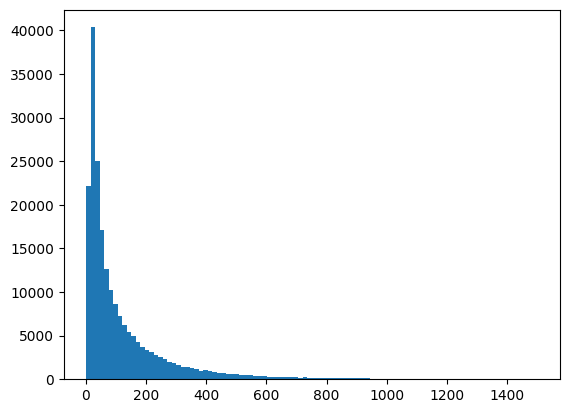

In [20]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Preprocessing

#### Creating validation data

In [21]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=1/9, random_state=1)

strat_train_set[:5]

,text,class
185289,Need some advice I’d appreciate if people won’...,0
135507,"Dear Magic Eye Bot I hate you,\nI never wanna ...",0
213617,If there's any teachers in this sub Why do you...,0
137338,I am now officially closer to 30 years of age ...,0
20632,Sure the royal family racism thing is interest...,0


#### Tokenizing the posts

In [22]:
import spacy

print(spacy.prefer_gpu())

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

nlp.pipe_names

True


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [23]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['read', 'paper']


In [51]:
import pickle
from tqdm import tqdm

def preprocess_set(set, directory):
    print(f'Preprocessing {directory} data')

    texts = set.copy()['text']
    labels = set.copy()['class']
    texts = [' '.join(text.split()[:500]) for text in texts]

    docs = (doc for doc in (nlp.pipe(texts)))
    processed_texts = []
    for doc in tqdm(docs, total=len(texts), ncols=80):
        lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(' '.join(lemmas))
    
    labels = np.array(labels)

    from pathlib import Path
    Path(f"{directory}").mkdir(parents=True, exist_ok=True)

    with open(f"{directory}/texts.pkl", "wb") as fp:
        pickle.dump(processed_texts, fp)
    
    with open(f"{directory}/labels.pkl", "wb") as fp:
        pickle.dump(labels, fp)

    return processed_texts, labels

In [52]:
len(strat_train_set)

185658

In [53]:
preprocess_set(strat_train_set, 'train')
preprocess_set(strat_val_set, 'val')
preprocess_set(strat_test_set, 'test')

print()

Preprocessing train data


100%|██████████████████████████████████| 185658/185658 [05:34<00:00, 554.97it/s]


Preprocessing val data


100%|████████████████████████████████████| 23208/23208 [00:38<00:00, 604.47it/s]


Preprocessing test data


100%|████████████████████████████████████| 23208/23208 [00:37<00:00, 623.86it/s]